In [1]:
%matplotlib inline

import copy
from datetime import date
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
import time
import torch as pt
import pickle

sys.path.insert(0, '..')

from function_space import DenseNet, DenseNet_tanh
from problems import ExponentialOnBallNonlinearSin
from solver import EllipticSolver
from utilities import plot_loss_logs_extended, plot_moving_average

%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

In [2]:
with open('../TD_Model_Correct_TD_112922.pickle', 'rb') as f:
    model_td = pickle.load(f)
with open('../TD_Model_delta_t_01_112922.pickle', 'rb') as f:
    model_td_01 = pickle.load(f)
with open('../TD_Model_delta_t_1_112922.pickle', 'rb') as f:
    model_td_1 = pickle.load(f)

In [3]:
with open('../Diffusion_Model_112922.pickle', 'rb') as f:
    model_diff = pickle.load(f)

In [4]:
with open('../PINN_Model_112922.pickle', 'rb') as f:
    model_pinn = pickle.load(f)

In [5]:
with open('../New_Method_Working_113022.pickle', 'rb') as f:
    model_new = pickle.load(f)

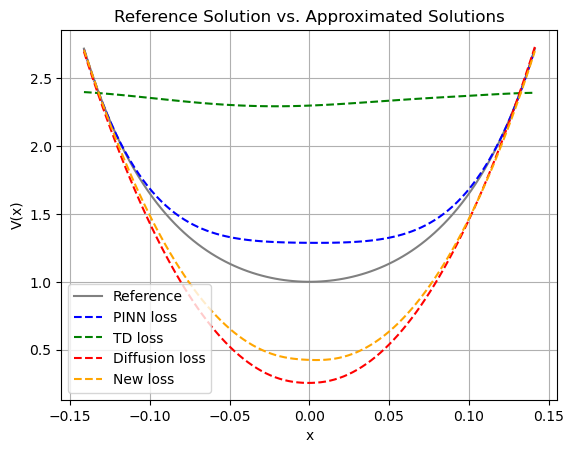

In [6]:
d = 50
L = 220000
print_every = 500
delta_t = 0.001
N = 20

problem = ExponentialOnBallNonlinearSin(d=d)

X = pt.cat([pt.linspace(-1 / np.sqrt(d), 1 / np.sqrt(d), 100).unsqueeze(1).repeat(1, d)], 1).to(device)

plt.plot(X[:, 0].detach().cpu().numpy(), problem.v_true(X.detach()).squeeze().cpu().numpy(), color='gray', label='Reference')
plt.plot(X[:, 0].detach().cpu().numpy(), model_pinn.V(X).detach().cpu().numpy()[:, 0], '--', color='blue', label='PINN loss')
plt.plot(X[:, 0].detach().cpu().numpy(), model_td_1.V(X).detach().cpu().numpy()[:, 0], '--', color='green', label='TD loss')
plt.plot(X[:, 0].detach().cpu().numpy(), model_diff.V(X).detach().cpu().numpy()[:, 0], '--', color='red', label='Diffusion loss')
plt.plot(X[:, 0].detach().cpu().numpy(), model_new.V(X).detach().cpu().numpy()[:, 0], '--', color='orange', label='New loss')

plt.xlabel("x")
plt.ylabel("V(x)")
plt.title("Reference Solution vs. Approximated Solutions")

plt.grid()
plt.legend()
plt.show()

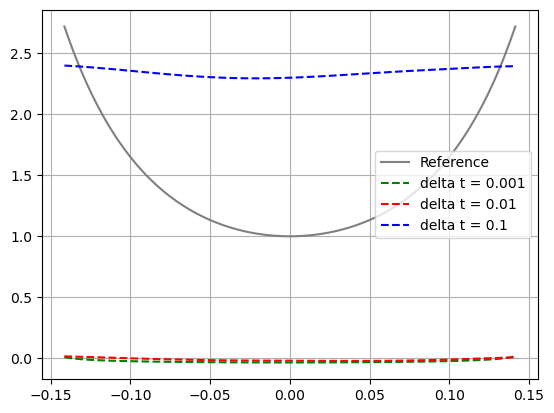

In [7]:
d = 50
L = 220000
print_every = 500
delta_t = 0.001
N = 20

problem = ExponentialOnBallNonlinearSin(d=d)

X = pt.cat([pt.linspace(-1 / np.sqrt(d), 1 / np.sqrt(d), 100).unsqueeze(1).repeat(1, d)], 1).to(device)

plt.plot(X[:, 0].detach().cpu().numpy(), problem.v_true(X.detach()).squeeze().cpu().numpy(), color='gray', label='Reference')
plt.plot(X[:, 0].detach().cpu().numpy(), model_td.V(X).detach().cpu().numpy()[:, 0], '--', color='green', label='delta t = 0.001')
plt.plot(X[:, 0].detach().cpu().numpy(), model_td_01.V(X).detach().cpu().numpy()[:, 0], '--', color='red', label='delta t = 0.01')
plt.plot(X[:, 0].detach().cpu().numpy(), model_td_1.V(X).detach().cpu().numpy()[:, 0], '--', color='blue', label='delta t = 0.1')

plt.grid()
plt.legend()
plt.show()

In [8]:
models = [model_pinn, model_diff, model_td, model_new]

In [9]:
moving_span = 400

def ma(x):
    return [np.mean(x[i:i + moving_span]) for i in range(len(x) - moving_span)]

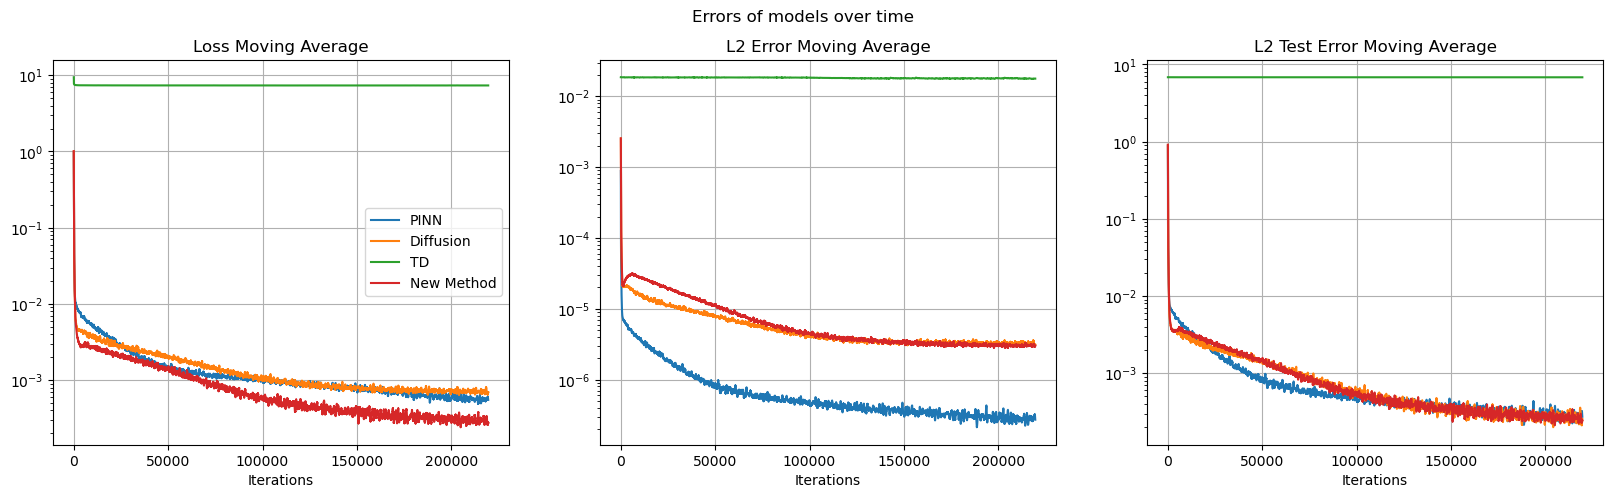

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

fig.suptitle("Errors of models over time")

for model in models:
    ax[0].plot(ma(model.loss_log), label=model.name)
    ax[0].set_yscale('log');
    ax[0].set_xlabel('Iterations')

    ax[0].legend()
    ax[1].plot(ma(model.V_L2_log))
    ax[1].set_xlabel('Iterations')
    ax[1].set_yscale('log');
    #ax[2].plot(model.V_test_rel_abs)
    #ax[2].set_xlabel('iterations')
    #ax[2].set_yscale('log');

    ax[2].plot(ma(model.V_test_L2))
    ax[2].set_xlabel('Iterations')
    ax[2].set_yscale('log');
ax[0].set_title('Loss Moving Average')
ax[1].set_title(r'L2 Error Moving Average');
#ax[2].set_title(r'relative absolute test error')
ax[2].set_title(r'L2 Test Error Moving Average')
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show()

#fig.tight_layout(rect=[0, 0.03, 1, 0.93])

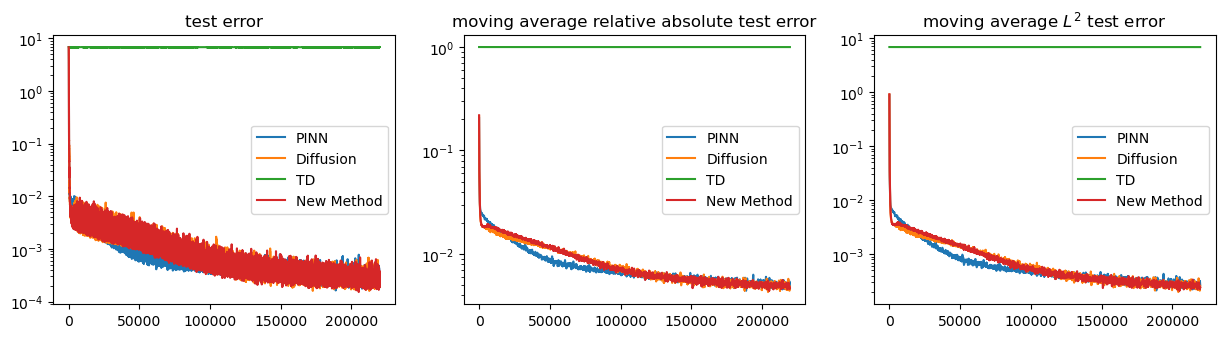

In [11]:
moving_span = 400

fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))

ax[0].set_title('test error')
for model in models:
    ax[0].plot(model.V_test_L2, label=model.name)
ax[0].set_yscale('log')
ax[0].legend()

ax[1].set_title('moving average relative absolute test error')
for model in models:
    ax[1].plot([np.mean(model.V_test_rel_abs[i:i + moving_span]) for i in range(len(model.V_test_rel_abs) - moving_span)], label=model.name)
ax[1].set_yscale('log')
ax[1].legend()

ax[2].set_title(r'moving average L2 test error')
for model in models:
    ax[2].plot([np.mean(model.V_test_L2[i:i + moving_span]) for i in range(len(model.V_test_L2) - moving_span)], label=model.name)
ax[2].set_yscale('log')
ax[2].legend()

In [12]:
with open('../New_Method2_dt_error_0005_120422.pickle', 'rb') as f:
    model_new_dt_0005 = pickle.load(f)
with open('../New_Method2_dt_error_001_120422.pickle', 'rb') as f:
    model_new_dt_001 = pickle.load(f)
with open('../New_Method2_dt_error_002_120422.pickle', 'rb') as f:
    model_new_dt_002 = pickle.load(f)
with open('../New_Method2_dt_error_0_120422.pickle', 'rb') as f:
    model_new_dt_0 = pickle.load(f)

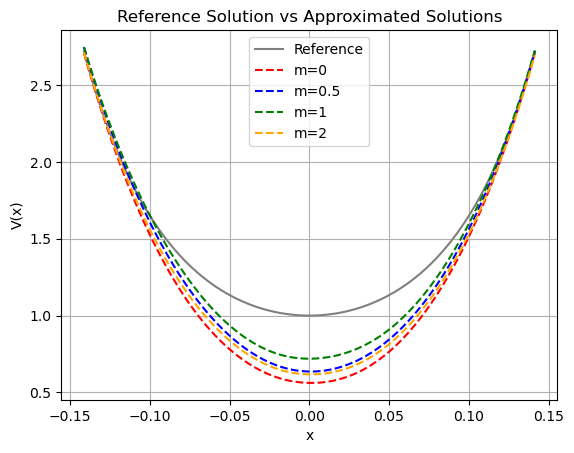

In [14]:
d = 50
print_every = 500
N = 20

problem = ExponentialOnBallNonlinearSin(d=d)

X = pt.cat([pt.linspace(-1 / np.sqrt(d), 1 / np.sqrt(d), 100).unsqueeze(1).repeat(1, d)], 1).to(device)

plt.plot(X[:, 0].detach().cpu().numpy(), problem.v_true(X.detach()).squeeze().cpu().numpy(), color='gray', label='Reference')
plt.plot(X[:, 0].detach().cpu().numpy(), model_new_dt_0.V(X).detach().cpu().numpy()[:, 0], '--', color='red', label='m=0')
plt.plot(X[:, 0].detach().cpu().numpy(), model_new_dt_0005.V(X).detach().cpu().numpy()[:, 0], '--', color='blue', label='m=0.5')


plt.plot(X[:, 0].detach().cpu().numpy(), model_new_dt_001.V(X).detach().cpu().numpy()[:, 0], '--', color='green', label='m=1')


plt.plot(X[:, 0].detach().cpu().numpy(), model_new_dt_002.V(X).detach().cpu().numpy()[:, 0], '--', color='orange', label='m=2')



plt.xlabel("x")
plt.ylabel("V(x)")
plt.title("Reference Solution vs Approximated Solutions")

plt.grid()
plt.legend()
plt.show()